# Análisis Completo de Machine Learning - Yeast Dataset
## Proyecto Final - Base de Datos II

Este notebook contiene un análisis exhaustivo del dataset Yeast aplicando:
- Imputación de valores (Forward/Backward fill, KNNImputer)
- Regularización (Ridge, Lasso, Elastic Net)
- Detección de outliers (PyOD)
- Selección de características (Boruta, Lasso, Stepwise)
- Árboles de decisión con optimización de hiperparámetros
- Comparativa de modelos

## 1. Importar Librerías

In [74]:
# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Preprocesamiento
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer

# Modelos de regularización
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LogisticRegression

# Detección de outliers
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
from pyod.models.lof import LOF

# Selección de características
from sklearn.feature_selection import RFE, RFECV, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Árboles de decisión
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

# Métricas
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                             precision_score, recall_score, f1_score, roc_auc_score,
                             mean_squared_error, r2_score, mean_absolute_error)

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print("✓ Todas las librerías importadas correctamente")

✓ Todas las librerías importadas correctamente


## 2. Carga y Exploración de Datos

In [75]:
# Cargar el dataset
column_names = ['Sequence_Name', 'mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc', 'class']
df = pd.read_csv('DATABASE/yeast.data', delim_whitespace=True, names=column_names)

print("Dimensiones del dataset:", df.shape)
print("\nPrimeras filas:")
df.head(10)

Dimensiones del dataset: (1484, 10)

Primeras filas:


,Sequence_Name,mcg,gvh,alm,mit,erl,pox,vac,nuc,class
0,ADT1_YEAST,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,ADT2_YEAST,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,ADT3_YEAST,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,AAR2_YEAST,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,AATM_YEAST,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT
5,AATC_YEAST,0.51,0.40,0.56,0.17,0.5,0.5,0.49,0.22,CYT
6,ABC1_YEAST,0.50,0.54,0.48,0.65,0.5,0.0,0.53,0.22,MIT
7,BAF1_YEAST,0.48,0.45,0.59,0.20,0.5,0.0,0.58,0.34,NUC
8,ABF2_YEAST,0.55,0.50,0.66,0.36,0.5,0.0,0.49,0.22,MIT
9,ABP1_YEAST,0.40,0.39,0.60,0.15,0.5,0.0,0.58,0.30,CYT


In [76]:
# Información del dataset
print("Información del dataset:")
print(df.info())
print("\n" + "="*50)
print("Estadísticas descriptivas:")
df.describe()

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1484 entries, 0 to 1483
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sequence_Name  1484 non-null   object 
 1   mcg            1484 non-null   float64
 2   gvh            1484 non-null   float64
 3   alm            1484 non-null   float64
 4   mit            1484 non-null   float64
 5   erl            1484 non-null   float64
 6   pox            1484 non-null   float64
 7   vac            1484 non-null   float64
 8   nuc            1484 non-null   float64
 9   class          1484 non-null   object 
dtypes: float64(8), object(2)
memory usage: 116.1+ KB
None

Estadísticas descriptivas:


,mcg,gvh,alm,mit,erl,pox,vac,nuc
count,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000
mean,0.500121,0.499933,0.500034,0.261186,0.504717,0.007500,0.499885,0.276199
std,0.137299,0.123924,0.086670,0.137098,0.048351,0.075683,0.057797,0.106491
min,0.110000,0.130000,0.210000,0.000000,0.500000,0.000000,0.000000,0.000000
25%,0.410000,0.420000,0.460000,0.170000,0.500000,0.000000,0.480000,0.220000
50%,0.490000,0.490000,0.510000,0.220000,0.500000,0.000000,0.510000,0.220000
75%,0.580000,0.570000,0.550000,0.320000,0.500000,0.000000,0.530000,0.300000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.830000,0.730000,1.000000


Distribución de clases:
class
CYT    463
NUC    429
MIT    244
ME3    163
ME2     51
ME1     44
EXC     35
VAC     30
POX     20
ERL      5
Name: count, dtype: int64

Número de clases: 10


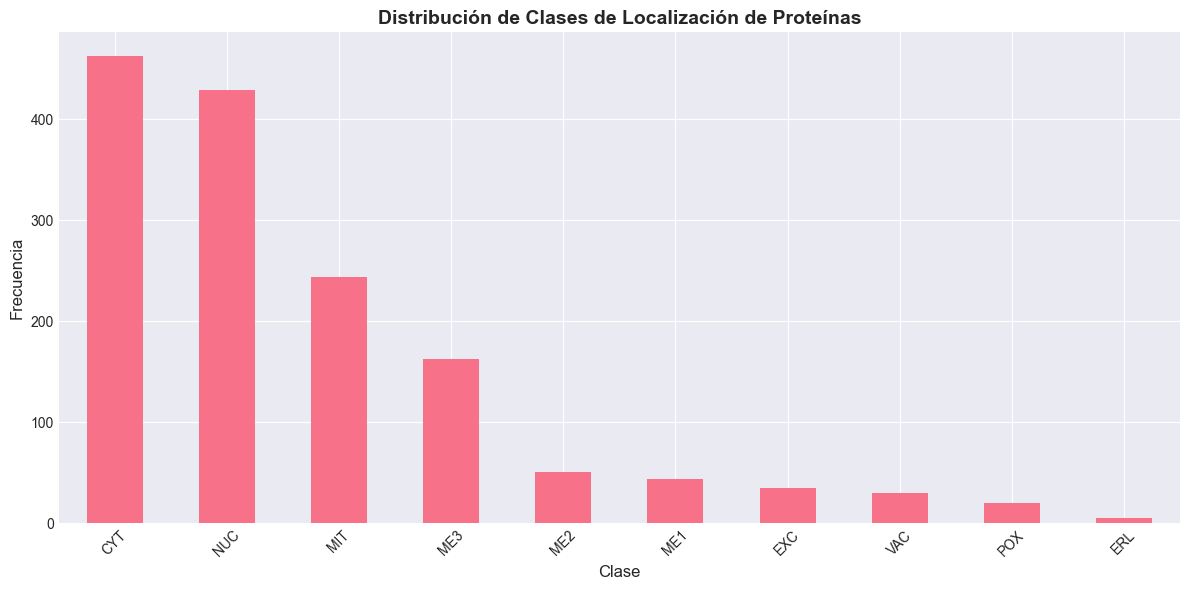

In [77]:
# Distribución de clases
print("Distribución de clases:")
print(df['class'].value_counts())
print(f"\nNúmero de clases: {df['class'].nunique()}")

# Visualizar distribución
plt.figure(figsize=(12, 6))
df['class'].value_counts().plot(kind='bar')
plt.title('Distribución de Clases de Localización de Proteínas', fontsize=14, fontweight='bold')
plt.xlabel('Clase', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [78]:
# Verificar valores faltantes
print("Valores faltantes por columna:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])
print(f"\nTotal de valores faltantes: {df.isnull().sum().sum()}")

Valores faltantes por columna:
Series([], dtype: int64)

Total de valores faltantes: 0


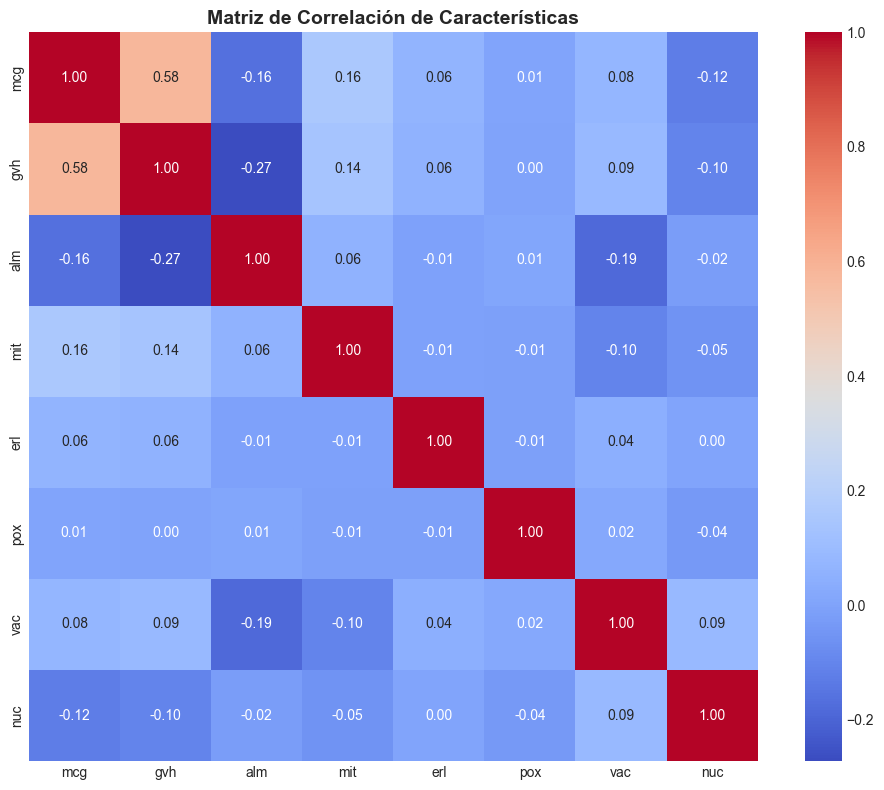

In [79]:
# Matriz de correlación
plt.figure(figsize=(10, 8))
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Matriz de Correlación de Características', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3. Preparación de Datos

In [80]:
# Separar características y target
X = df.drop(['Sequence_Name', 'class'], axis=1)
y = df['class']

# Codificar variable objetivo
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"Características: {X.shape}")
print(f"Target: {y.shape}")
print(f"\nClases codificadas: {dict(zip(le.classes_, le.transform(le.classes_)))}")

Características: (1484, 8)
Target: (1484,)

Clases codificadas: {'CYT': 0, 'ERL': 1, 'EXC': 2, 'ME1': 3, 'ME2': 4, 'ME3': 5, 'MIT': 6, 'NUC': 7, 'POX': 8, 'VAC': 9}


## 4. Imputación de Valores Faltantes

Aunque el dataset original no tiene valores faltantes, vamos a introducir algunos artificialmente para demostrar las técnicas de imputación.

In [81]:
# Crear una copia del dataset y añadir valores faltantes artificialmente
np.random.seed(42)
X_with_missing = X.copy()

# Introducir 5% de valores faltantes aleatoriamente
mask = np.random.random(X_with_missing.shape) < 0.05
X_with_missing = X_with_missing.mask(mask)

print(f"Valores faltantes introducidos: {X_with_missing.isnull().sum().sum()}")
print(f"Porcentaje de valores faltantes: {(X_with_missing.isnull().sum().sum() / X_with_missing.size) * 100:.2f}%")
print("\nValores faltantes por columna:")
print(X_with_missing.isnull().sum())

Valores faltantes introducidos: 596
Porcentaje de valores faltantes: 5.02%

Valores faltantes por columna:
mcg    78
gvh    72
alm    82
mit    75
erl    63
pox    77
vac    68
nuc    81
dtype: int64


### 4.1 Forward Fill y Backward Fill

In [82]:
# Forward Fill
X_ffill = X_with_missing.fillna(method='ffill')
# Backward Fill para los valores que quedaron al inicio
X_ffill = X_ffill.fillna(method='bfill')

print("Imputación con Forward/Backward Fill:")
print(f"Valores faltantes restantes: {X_ffill.isnull().sum().sum()}")
print("\nEstadísticas después de Forward Fill:")
print(X_ffill.describe())

Imputación con Forward/Backward Fill:
Valores faltantes restantes: 0

Estadísticas después de Forward Fill:
               mcg         gvh          alm          mit          erl  \
count  1484.000000  1484.00000  1484.000000  1484.000000  1484.000000   
mean      0.501826     0.50002     0.499973     0.261752     0.504717   
std       0.137328     0.12471     0.085993     0.136809     0.048351   
min       0.110000     0.13000     0.210000     0.000000     0.500000   
25%       0.410000     0.42000     0.460000     0.170000     0.500000   
50%       0.490000     0.49000     0.510000     0.220000     0.500000   
75%       0.580000     0.57000     0.550000     0.320000     0.500000   
max       1.000000     1.00000     1.000000     1.000000     1.000000   

               pox          vac          nuc  
count  1484.000000  1484.000000  1484.000000  
mean      0.007500     0.499912     0.275991  
std       0.075683     0.057511     0.104859  
min       0.000000     0.000000     0.000000  

### 4.2 KNN Imputer

In [83]:
# KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)
X_knn_imputed = pd.DataFrame(
    knn_imputer.fit_transform(X_with_missing),
    columns=X.columns,
    index=X.index
)

print("Imputación con KNN Imputer (k=5):")
print(f"Valores faltantes restantes: {X_knn_imputed.isnull().sum().sum()}")
print("\nEstadísticas después de KNN Imputer:")
print(X_knn_imputed.describe())

Imputación con KNN Imputer (k=5):
Valores faltantes restantes: 0

Estadísticas después de KNN Imputer:
               mcg          gvh          alm          mit          erl  \
count  1484.000000  1484.000000  1484.000000  1484.000000  1484.000000   
mean      0.500274     0.499389     0.499783     0.262226     0.504987   
std       0.134401     0.122146     0.084689     0.134882     0.048602   
min       0.110000     0.130000     0.210000     0.000000     0.500000   
25%       0.410000     0.420000     0.460000     0.170000     0.500000   
50%       0.489000     0.490000     0.510000     0.220000     0.500000   
75%       0.570000     0.570000     0.550000     0.320000     0.500000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

               pox          vac          nuc  
count  1484.000000  1484.000000  1484.000000  
mean      0.008038     0.500026     0.276473  
std       0.076128     0.056780     0.103424  
min       0.000000     0.000000     0.0000

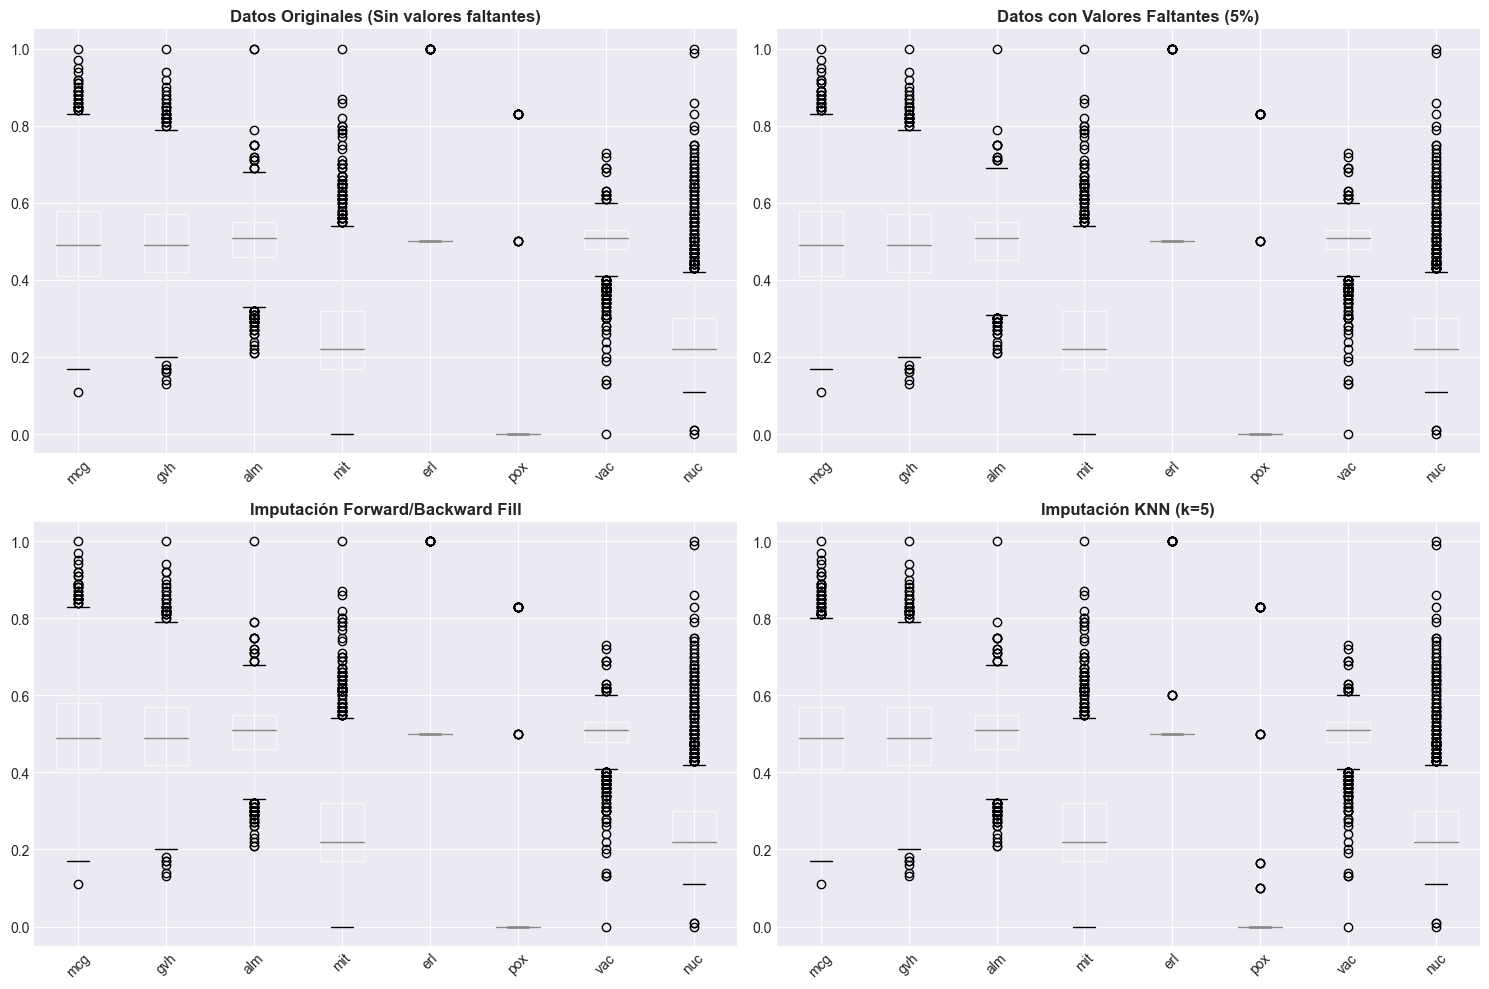

In [84]:
# Comparar imputaciones
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Original
X.boxplot(ax=axes[0, 0])
axes[0, 0].set_title('Datos Originales (Sin valores faltantes)', fontweight='bold')
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45)

# Con valores faltantes
X_with_missing.boxplot(ax=axes[0, 1])
axes[0, 1].set_title('Datos con Valores Faltantes (5%)', fontweight='bold')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45)

# Forward Fill
X_ffill.boxplot(ax=axes[1, 0])
axes[1, 0].set_title('Imputación Forward/Backward Fill', fontweight='bold')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45)

# KNN Imputer
X_knn_imputed.boxplot(ax=axes[1, 1])
axes[1, 1].set_title('Imputación KNN (k=5)', fontweight='bold')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

## 5. Detección de Outliers con PyOD

In [85]:
# Usar datos originales sin valores faltantes
X_clean = X.copy()

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

# Método 1: KNN (K-Nearest Neighbors)
knn_detector = KNN(contamination=0.1)
knn_labels = knn_detector.fit_predict(X_scaled)
knn_scores = knn_detector.decision_scores_

print("Detección de Outliers con KNN:")
print(f"Outliers detectados: {np.sum(knn_labels)}")
print(f"Porcentaje de outliers: {(np.sum(knn_labels) / len(knn_labels)) * 100:.2f}%")

Detección de Outliers con KNN:
Outliers detectados: 149
Porcentaje de outliers: 10.04%


In [86]:
# Método 2: Isolation Forest
iforest_detector = IForest(contamination=0.1, random_state=42)
iforest_labels = iforest_detector.fit_predict(X_scaled)
iforest_scores = iforest_detector.decision_scores_

print("Detección de Outliers con Isolation Forest:")
print(f"Outliers detectados: {np.sum(iforest_labels)}")
print(f"Porcentaje de outliers: {(np.sum(iforest_labels) / len(iforest_labels)) * 100:.2f}%")

Detección de Outliers con Isolation Forest:
Outliers detectados: 149
Porcentaje de outliers: 10.04%


In [87]:
# Método 3: Local Outlier Factor (LOF)
lof_detector = LOF(contamination=0.1)
lof_labels = lof_detector.fit_predict(X_scaled)
lof_scores = lof_detector.decision_scores_

print("Detección de Outliers con LOF:")
print(f"Outliers detectados: {np.sum(lof_labels)}")
print(f"Porcentaje de outliers: {(np.sum(lof_labels) / len(lof_labels)) * 100:.2f}%")

Detección de Outliers con LOF:
Outliers detectados: 149
Porcentaje de outliers: 10.04%


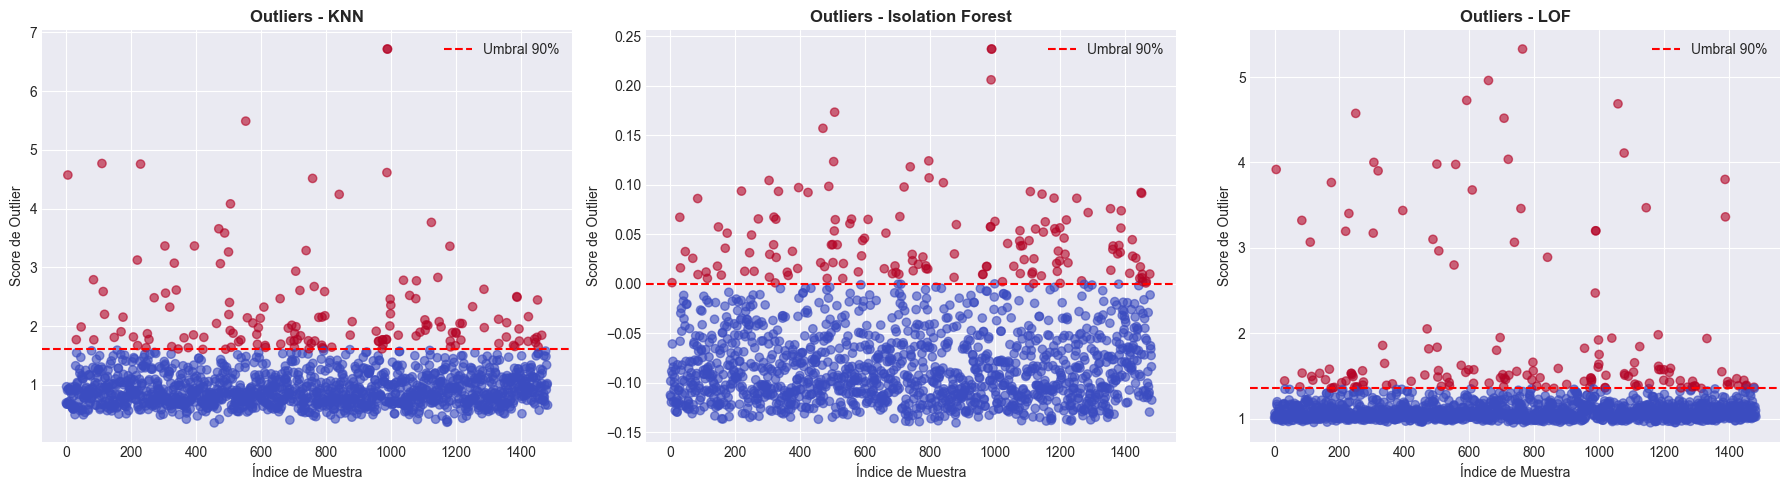

In [88]:
# Visualizar outliers detectados
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

methods = [
    ('KNN', knn_labels, knn_scores),
    ('Isolation Forest', iforest_labels, iforest_scores),
    ('LOF', lof_labels, lof_scores)
]

for idx, (name, labels, scores) in enumerate(methods):
    axes[idx].scatter(range(len(scores)), scores, c=labels, cmap='coolwarm', alpha=0.6)
    axes[idx].set_title(f'Outliers - {name}', fontweight='bold')
    axes[idx].set_xlabel('Índice de Muestra')
    axes[idx].set_ylabel('Score de Outlier')
    axes[idx].axhline(y=np.percentile(scores, 90), color='r', linestyle='--', label='Umbral 90%')
    axes[idx].legend()

plt.tight_layout()
plt.show()

In [89]:
# Crear dataset sin outliers (usando consenso de los 3 métodos)
# Un punto es outlier si al menos 2 de 3 métodos lo detectan
outlier_consensus = (knn_labels + iforest_labels + lof_labels) >= 2
X_no_outliers = X_clean[~outlier_consensus]
y_no_outliers = y_encoded[~outlier_consensus]

print(f"Dataset original: {X_clean.shape}")
print(f"Dataset sin outliers (consenso): {X_no_outliers.shape}")
print(f"Outliers removidos: {np.sum(outlier_consensus)}")

Dataset original: (1484, 8)
Dataset sin outliers (consenso): (1342, 8)
Outliers removidos: 142


## 6. Selección de Características

### 6.1 Método RFE (Recursive Feature Elimination)

RFE es una alternativa robusta a Boruta que elimina recursivamente las características menos importantes.

In [90]:
# RFE (Recursive Feature Elimination) para selección de características
print("Ejecutando RFE (esto puede tomar unos minutos)...")

# Usar RandomForest como estimador
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)

# RFE con cross-validation para seleccionar el número óptimo de características
rfecv = RFECV(estimator=rf, step=1, cv=5, scoring='accuracy', n_jobs=-1)
rfecv.fit(X_no_outliers, y_no_outliers)

# Características seleccionadas
rfe_selected = X_no_outliers.columns[rfecv.support_].tolist()
rfe_ranking = pd.DataFrame({
    'Feature': X_no_outliers.columns,
    'Ranking': rfecv.ranking_,
    'Selected': rfecv.support_
}).sort_values('Ranking')

print("\nResultados RFE:")
print(rfe_ranking)
print(f"\nCaracterísticas seleccionadas: {rfe_selected}")
print(f"Número óptimo de características: {rfecv.n_features_}")
print(f"Score con características seleccionadas: {rfecv.cv_results_['mean_test_score'][rfecv.n_features_ - 1]:.4f}")

Ejecutando RFE (esto puede tomar unos minutos)...

Resultados RFE:
  Feature  Ranking  Selected
0     mcg        1      True
1     gvh        1      True
2     alm        1      True
3     mit        1      True
5     pox        1      True
6     vac        1      True
7     nuc        1      True
4     erl        2     False

Características seleccionadas: ['mcg', 'gvh', 'alm', 'mit', 'pox', 'vac', 'nuc']
Número óptimo de características: 7
Score con características seleccionadas: 0.6065


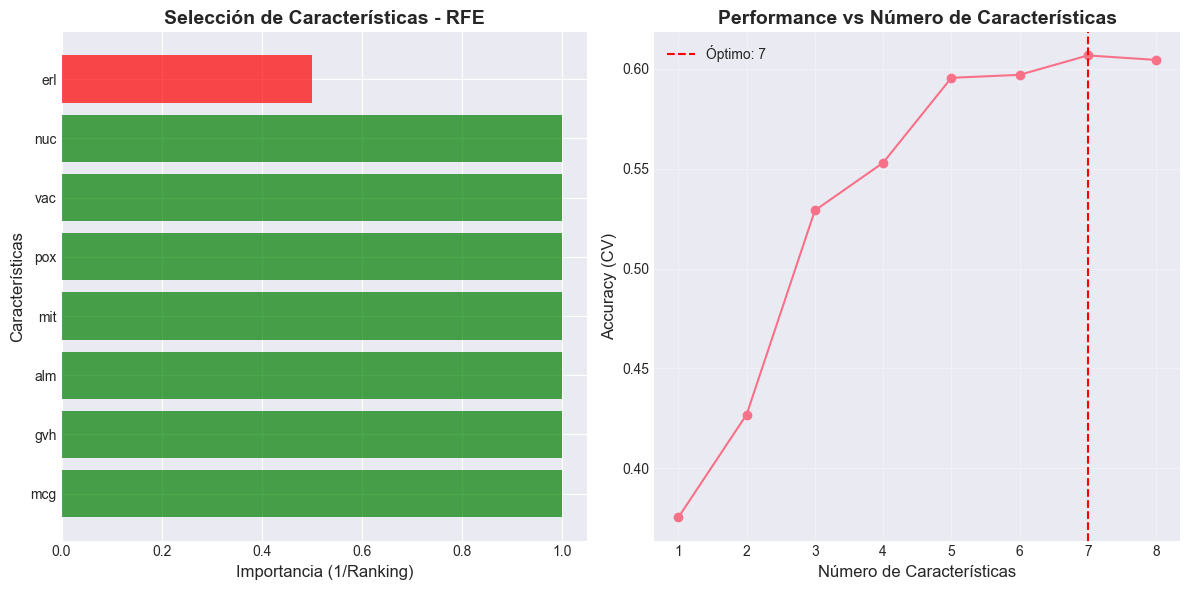

In [91]:
# Visualizar importancia de características según RFE
plt.figure(figsize=(12, 6))

# Subplot 1: Ranking de características
plt.subplot(1, 2, 1)
colors = ['green' if x else 'red' for x in rfe_ranking['Selected']]
plt.barh(rfe_ranking['Feature'], 1/rfe_ranking['Ranking'], color=colors, alpha=0.7)
plt.xlabel('Importancia (1/Ranking)', fontsize=12)
plt.ylabel('Características', fontsize=12)
plt.title('Selección de Características - RFE', fontsize=14, fontweight='bold')

# Subplot 2: Número de características vs Score
plt.subplot(1, 2, 2)
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), 
         rfecv.cv_results_['mean_test_score'], marker='o')
plt.xlabel('Número de Características', fontsize=12)
plt.ylabel('Accuracy (CV)', fontsize=12)
plt.title('Performance vs Número de Características', fontsize=14, fontweight='bold')
plt.axvline(x=rfecv.n_features_, color='r', linestyle='--', label=f'Óptimo: {rfecv.n_features_}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 6.2 Método Lasso (L1 Regularization)

In [92]:
# Usar Lasso para selección de características
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# Escalar datos
scaler_lasso = StandardScaler()
X_scaled_lasso = scaler_lasso.fit_transform(X_no_outliers)

# LassoCV para encontrar el mejor alpha
lasso_cv = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso_cv.fit(X_scaled_lasso, y_no_outliers)

# Coeficientes
lasso_coef = pd.DataFrame({
    'Feature': X_no_outliers.columns,
    'Coefficient': np.abs(lasso_cv.coef_)
}).sort_values('Coefficient', ascending=False)

# Características con coeficiente != 0
lasso_selected = lasso_coef[lasso_coef['Coefficient'] > 0]['Feature'].tolist()

print(f"Mejor alpha encontrado: {lasso_cv.alpha_:.4f}")
print(f"\nCaracterísticas con coeficiente != 0: {len(lasso_selected)}")
print("\nCoeficientes Lasso:")
print(lasso_coef)

Mejor alpha encontrado: 0.0457

Características con coeficiente != 0: 5

Coeficientes Lasso:
  Feature  Coefficient
3     mit     0.468522
7     nuc     0.459020
2     alm     0.300988
0     mcg     0.228177
6     vac     0.014210
1     gvh     0.000000
4     erl     0.000000
5     pox     0.000000


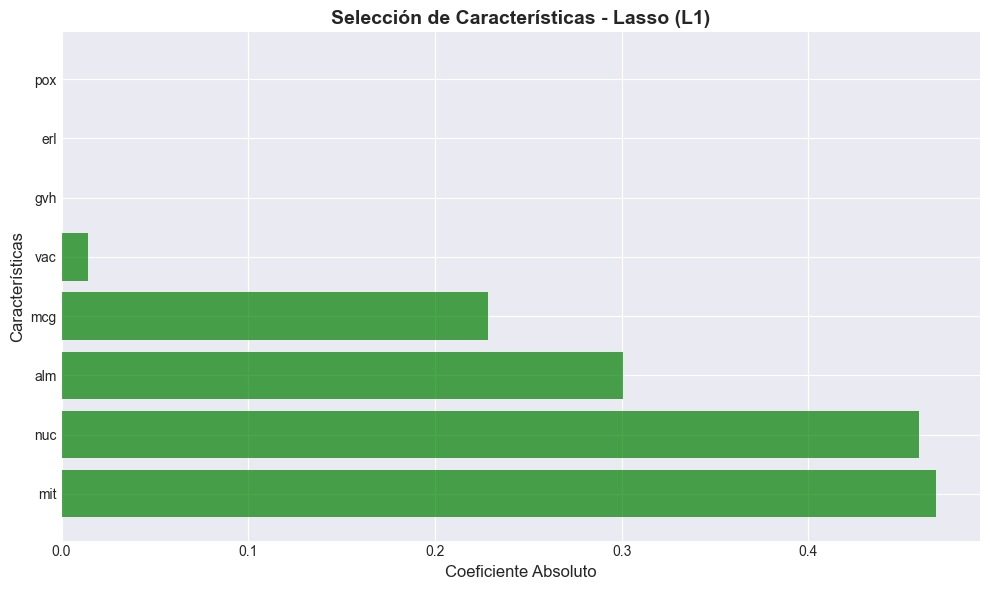

In [93]:
# Visualizar coeficientes Lasso
plt.figure(figsize=(10, 6))
colors_lasso = ['green' if x > 0 else 'red' for x in lasso_coef['Coefficient']]
plt.barh(lasso_coef['Feature'], lasso_coef['Coefficient'], color=colors_lasso, alpha=0.7)
plt.xlabel('Coeficiente Absoluto', fontsize=12)
plt.ylabel('Características', fontsize=12)
plt.title('Selección de Características - Lasso (L1)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 6.3 Método Stepwise (Forward Selection)

In [94]:
# Forward Stepwise Selection usando mlxtend
print("Ejecutando Forward Stepwise Selection (esto puede tomar unos minutos)...")

rf_stepwise = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Forward selection
sfs_forward = SFS(rf_stepwise, 
                  k_features=5,  # Seleccionar 5 características
                  forward=True, 
                  floating=False, 
                  scoring='accuracy',
                  cv=5,
                  n_jobs=-1)

sfs_forward.fit(X_no_outliers.values, y_no_outliers)

# Características seleccionadas
stepwise_selected_idx = list(sfs_forward.k_feature_idx_)
stepwise_selected = X_no_outliers.columns[stepwise_selected_idx].tolist()

print(f"\nCaracterísticas seleccionadas por Stepwise: {stepwise_selected}")
print(f"Score: {sfs_forward.k_score_:.4f}")

Ejecutando Forward Stepwise Selection (esto puede tomar unos minutos)...

Características seleccionadas por Stepwise: ['mcg', 'alm', 'mit', 'vac', 'nuc']
Score: 0.5752


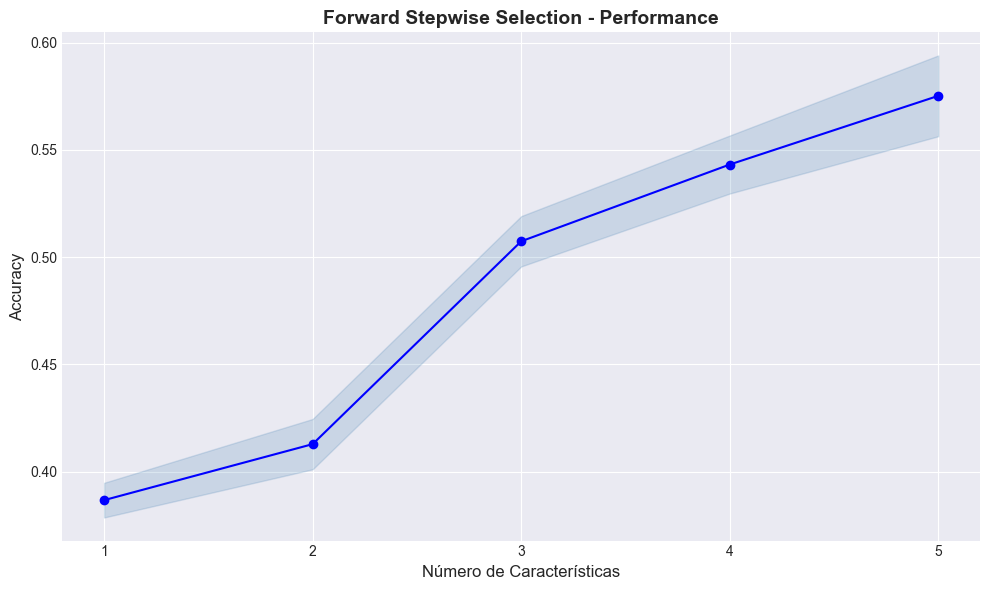

In [95]:
# Visualizar el proceso de selección stepwise
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs_forward.get_metric_dict(), kind='std_err', figsize=(10, 6))
plt.title('Forward Stepwise Selection - Performance', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Número de Características', fontsize=12)
plt.tight_layout()
plt.show()

### 6.4 Comparación de Métodos de Selección

In [96]:
# Comparar características seleccionadas por cada método
print("="*60)
print("COMPARACIÓN DE MÉTODOS DE SELECCIÓN DE CARACTERÍSTICAS")
print("="*60)

print(f"\nRFE: {len(rfe_selected)} características")
print(f"  {rfe_selected}")

print(f"\nLasso: {len(lasso_selected)} características")
print(f"  {lasso_selected}")

print(f"\nStepwise: {len(stepwise_selected)} características")
print(f"  {stepwise_selected}")

# Características en común
common_features = set(rfe_selected) & set(lasso_selected) & set(stepwise_selected)
print(f"\nCaracterísticas seleccionadas por los 3 métodos: {common_features}")

# Unión de todas las características
all_selected = set(rfe_selected) | set(lasso_selected) | set(stepwise_selected)
print(f"\nTotal de características únicas seleccionadas: {len(all_selected)}")
print(f"  {sorted(all_selected)}")

COMPARACIÓN DE MÉTODOS DE SELECCIÓN DE CARACTERÍSTICAS

RFE: 7 características
  ['mcg', 'gvh', 'alm', 'mit', 'pox', 'vac', 'nuc']

Lasso: 5 características
  ['mit', 'nuc', 'alm', 'mcg', 'vac']

Stepwise: 5 características
  ['mcg', 'alm', 'mit', 'vac', 'nuc']

Características seleccionadas por los 3 métodos: {'alm', 'nuc', 'mcg', 'mit', 'vac'}

Total de características únicas seleccionadas: 7
  ['alm', 'gvh', 'mcg', 'mit', 'nuc', 'pox', 'vac']


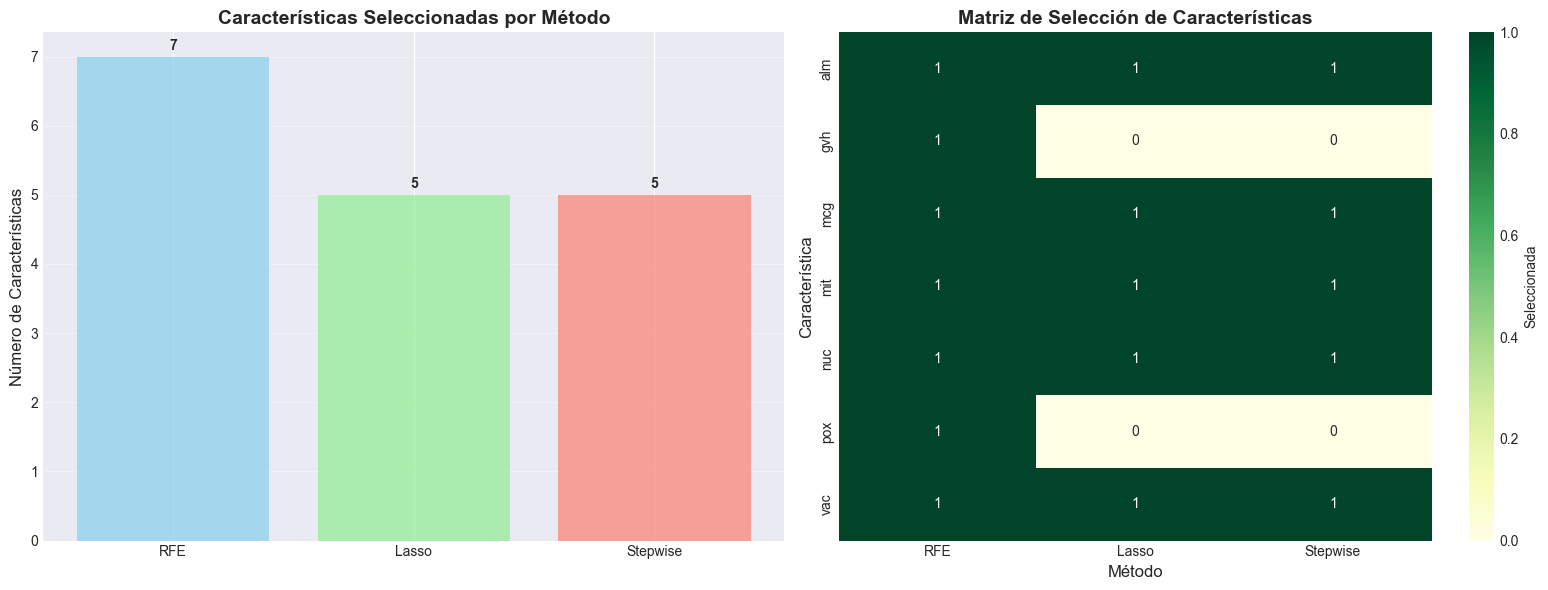

In [97]:
# Visualizar comparación de métodos
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Comparación de número de características
method_names = ['RFE', 'Lasso', 'Stepwise']
num_features = [len(rfe_selected), len(lasso_selected), len(stepwise_selected)]
colors_methods = ['skyblue', 'lightgreen', 'salmon']

axes[0].bar(method_names, num_features, color=colors_methods, alpha=0.7)
axes[0].set_ylabel('Número de Características', fontsize=12)
axes[0].set_title('Características Seleccionadas por Método', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(num_features):
    axes[0].text(i, v + 0.1, str(v), ha='center', fontweight='bold')

# Subplot 2: Matriz de selección (heatmap)
all_features = sorted(set(rfe_selected) | set(lasso_selected) | set(stepwise_selected))
selection_matrix = []
for feat in all_features:
    row = [
        1 if feat in rfe_selected else 0,
        1 if feat in lasso_selected else 0,
        1 if feat in stepwise_selected else 0
    ]
    selection_matrix.append(row)

selection_df = pd.DataFrame(selection_matrix, index=all_features, columns=['RFE', 'Lasso', 'Stepwise'])
sns.heatmap(selection_df, annot=True, fmt='d', cmap='YlGn', cbar_kws={'label': 'Seleccionada'}, ax=axes[1])
axes[1].set_title('Matriz de Selección de Características', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Método', fontsize=12)
axes[1].set_ylabel('Característica', fontsize=12)

plt.tight_layout()
plt.show()

## 7. Modelos de Regularización

In [98]:
# Preparar datos para modelado
X_train, X_test, y_train, y_test = train_test_split(
    X_no_outliers, y_no_outliers, test_size=0.3, random_state=42, stratify=y_no_outliers
)

# Escalar datos
scaler_model = StandardScaler()
X_train_scaled = scaler_model.fit_transform(X_train)
X_test_scaled = scaler_model.transform(X_test)

print(f"Conjunto de entrenamiento: {X_train.shape}")
print(f"Conjunto de prueba: {X_test.shape}")

Conjunto de entrenamiento: (939, 8)
Conjunto de prueba: (403, 8)


### 7.1 Ridge Regression (L2 Regularization)

In [99]:
# Ridge Regression con GridSearch
ridge_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
ridge = Ridge()
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
ridge_grid.fit(X_train_scaled, y_train)

print("Ridge Regression (L2):")
print(f"Mejor alpha: {ridge_grid.best_params_['alpha']}")
print(f"Mejor score (MSE negativo): {ridge_grid.best_score_:.4f}")

# Predicciones
ridge_pred = ridge_grid.predict(X_test_scaled)
ridge_mse = mean_squared_error(y_test, ridge_pred)
ridge_r2 = r2_score(y_test, ridge_pred)

print(f"MSE en test: {ridge_mse:.4f}")
print(f"R² en test: {ridge_r2:.4f}")

Ridge Regression (L2):
Mejor alpha: 100
Mejor score (MSE negativo): -8.6548
MSE en test: 8.8447
R² en test: 0.0494


### 7.2 Lasso Regression (L1 Regularization)

In [100]:
# Lasso Regression con GridSearch
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
lasso = Lasso(max_iter=10000)
lasso_grid = GridSearchCV(lasso, lasso_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
lasso_grid.fit(X_train_scaled, y_train)

print("Lasso Regression (L1):")
print(f"Mejor alpha: {lasso_grid.best_params_['alpha']}")
print(f"Mejor score (MSE negativo): {lasso_grid.best_score_:.4f}")

# Predicciones
lasso_pred = lasso_grid.predict(X_test_scaled)
lasso_mse = mean_squared_error(y_test, lasso_pred)
lasso_r2 = r2_score(y_test, lasso_pred)

print(f"MSE en test: {lasso_mse:.4f}")
print(f"R² en test: {lasso_r2:.4f}")

Lasso Regression (L1):
Mejor alpha: 0.01
Mejor score (MSE negativo): -8.6567
MSE en test: 8.8571
R² en test: 0.0481


### 7.3 Elastic Net

In [101]:
# Elastic Net con GridSearch
elastic_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}
elastic = ElasticNet(max_iter=10000)
elastic_grid = GridSearchCV(elastic, elastic_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
elastic_grid.fit(X_train_scaled, y_train)

print("Elastic Net:")
print(f"Mejor alpha: {elastic_grid.best_params_['alpha']}")
print(f"Mejor l1_ratio: {elastic_grid.best_params_['l1_ratio']}")
print(f"Mejor score (MSE negativo): {elastic_grid.best_score_:.4f}")

# Predicciones
elastic_pred = elastic_grid.predict(X_test_scaled)
elastic_mse = mean_squared_error(y_test, elastic_pred)
elastic_r2 = r2_score(y_test, elastic_pred)

print(f"MSE en test: {elastic_mse:.4f}")
print(f"R² en test: {elastic_r2:.4f}")

Elastic Net:
Mejor alpha: 0.1
Mejor l1_ratio: 0.1
Mejor score (MSE negativo): -8.6545
MSE en test: 8.8396
R² en test: 0.0499



COMPARACIÓN DE MODELOS DE REGULARIZACIÓN
     Modelo      MSE       R²
 Ridge (L2) 8.844700 0.049389
 Lasso (L1) 8.857062 0.048060
Elastic Net 8.839619 0.049935


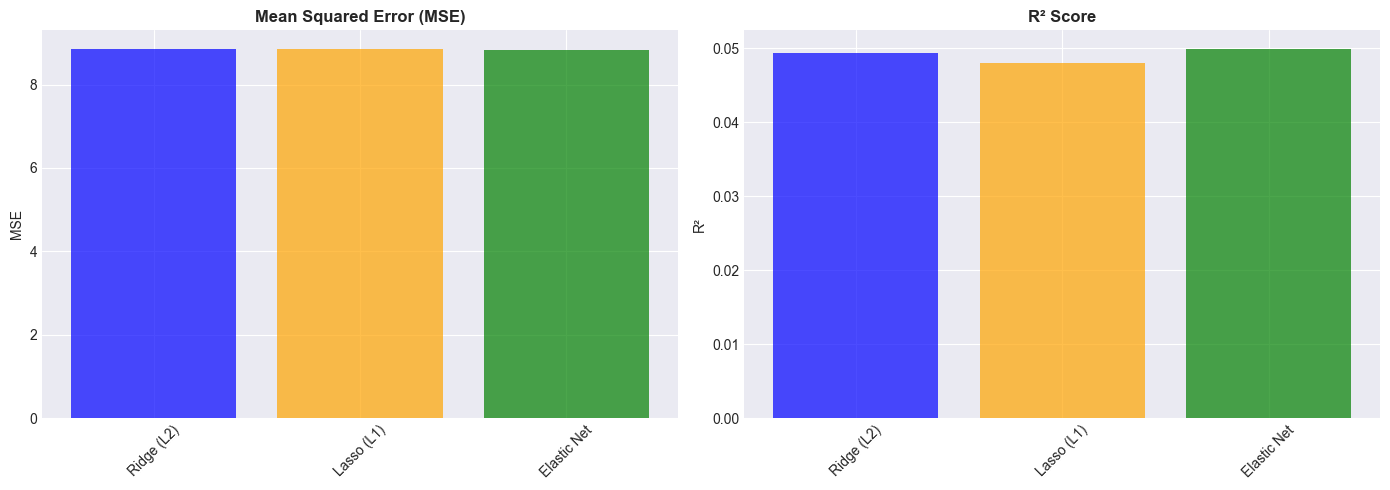

In [102]:
# Comparar modelos de regularización
regularization_results = pd.DataFrame({
    'Modelo': ['Ridge (L2)', 'Lasso (L1)', 'Elastic Net'],
    'MSE': [ridge_mse, lasso_mse, elastic_mse],
    'R²': [ridge_r2, lasso_r2, elastic_r2]
})

print("\n" + "="*60)
print("COMPARACIÓN DE MODELOS DE REGULARIZACIÓN")
print("="*60)
print(regularization_results.to_string(index=False))

# Visualizar comparación
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(regularization_results['Modelo'], regularization_results['MSE'], color=['blue', 'orange', 'green'], alpha=0.7)
axes[0].set_title('Mean Squared Error (MSE)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('MSE')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(regularization_results['Modelo'], regularization_results['R²'], color=['blue', 'orange', 'green'], alpha=0.7)
axes[1].set_title('R² Score', fontsize=12, fontweight='bold')
axes[1].set_ylabel('R²')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 8. Árboles de Decisión

### 8.1 Árbol de Clasificación

In [103]:
# Árbol de Clasificación con GridSearch
dt_clf_params = {
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy']
}

dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf_grid = GridSearchCV(dt_clf, dt_clf_params, cv=5, scoring='accuracy', n_jobs=-1)
dt_clf_grid.fit(X_train, y_train)

print("Árbol de Clasificación:")
print(f"Mejores hiperparámetros: {dt_clf_grid.best_params_}")
print(f"Mejor accuracy en CV: {dt_clf_grid.best_score_:.4f}")

# Predicciones
dt_clf_pred = dt_clf_grid.predict(X_test)
dt_clf_accuracy = accuracy_score(y_test, dt_clf_pred)
dt_clf_precision = precision_score(y_test, dt_clf_pred, average='weighted')
dt_clf_recall = recall_score(y_test, dt_clf_pred, average='weighted')
dt_clf_f1 = f1_score(y_test, dt_clf_pred, average='weighted')

print(f"\nMétricas en Test:")
print(f"Accuracy: {dt_clf_accuracy:.4f}")
print(f"Precision: {dt_clf_precision:.4f}")
print(f"Recall: {dt_clf_recall:.4f}")
print(f"F1-Score: {dt_clf_f1:.4f}")

Árbol de Clasificación:
Mejores hiperparámetros: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 20}
Mejor accuracy en CV: 0.5762

Métricas en Test:
Accuracy: 0.5955
Precision: 0.5971
Recall: 0.5955
F1-Score: 0.5815


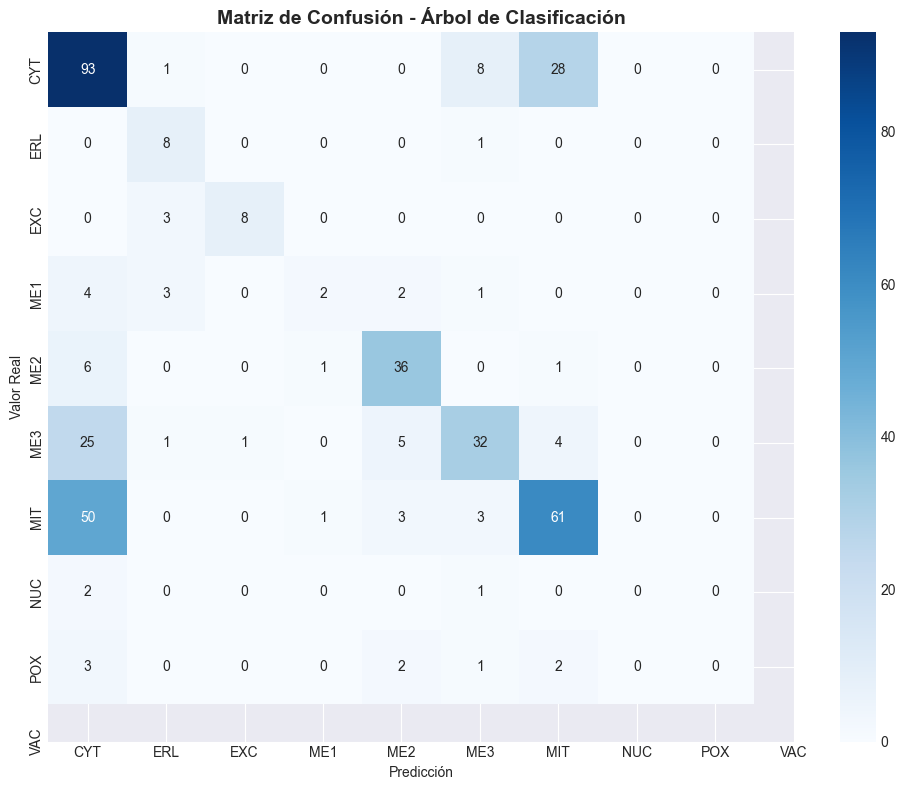

In [104]:
# Matriz de confusión
cm = confusion_matrix(y_test, dt_clf_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de Confusión - Árbol de Clasificación', fontsize=14, fontweight='bold')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.tight_layout()
plt.show()

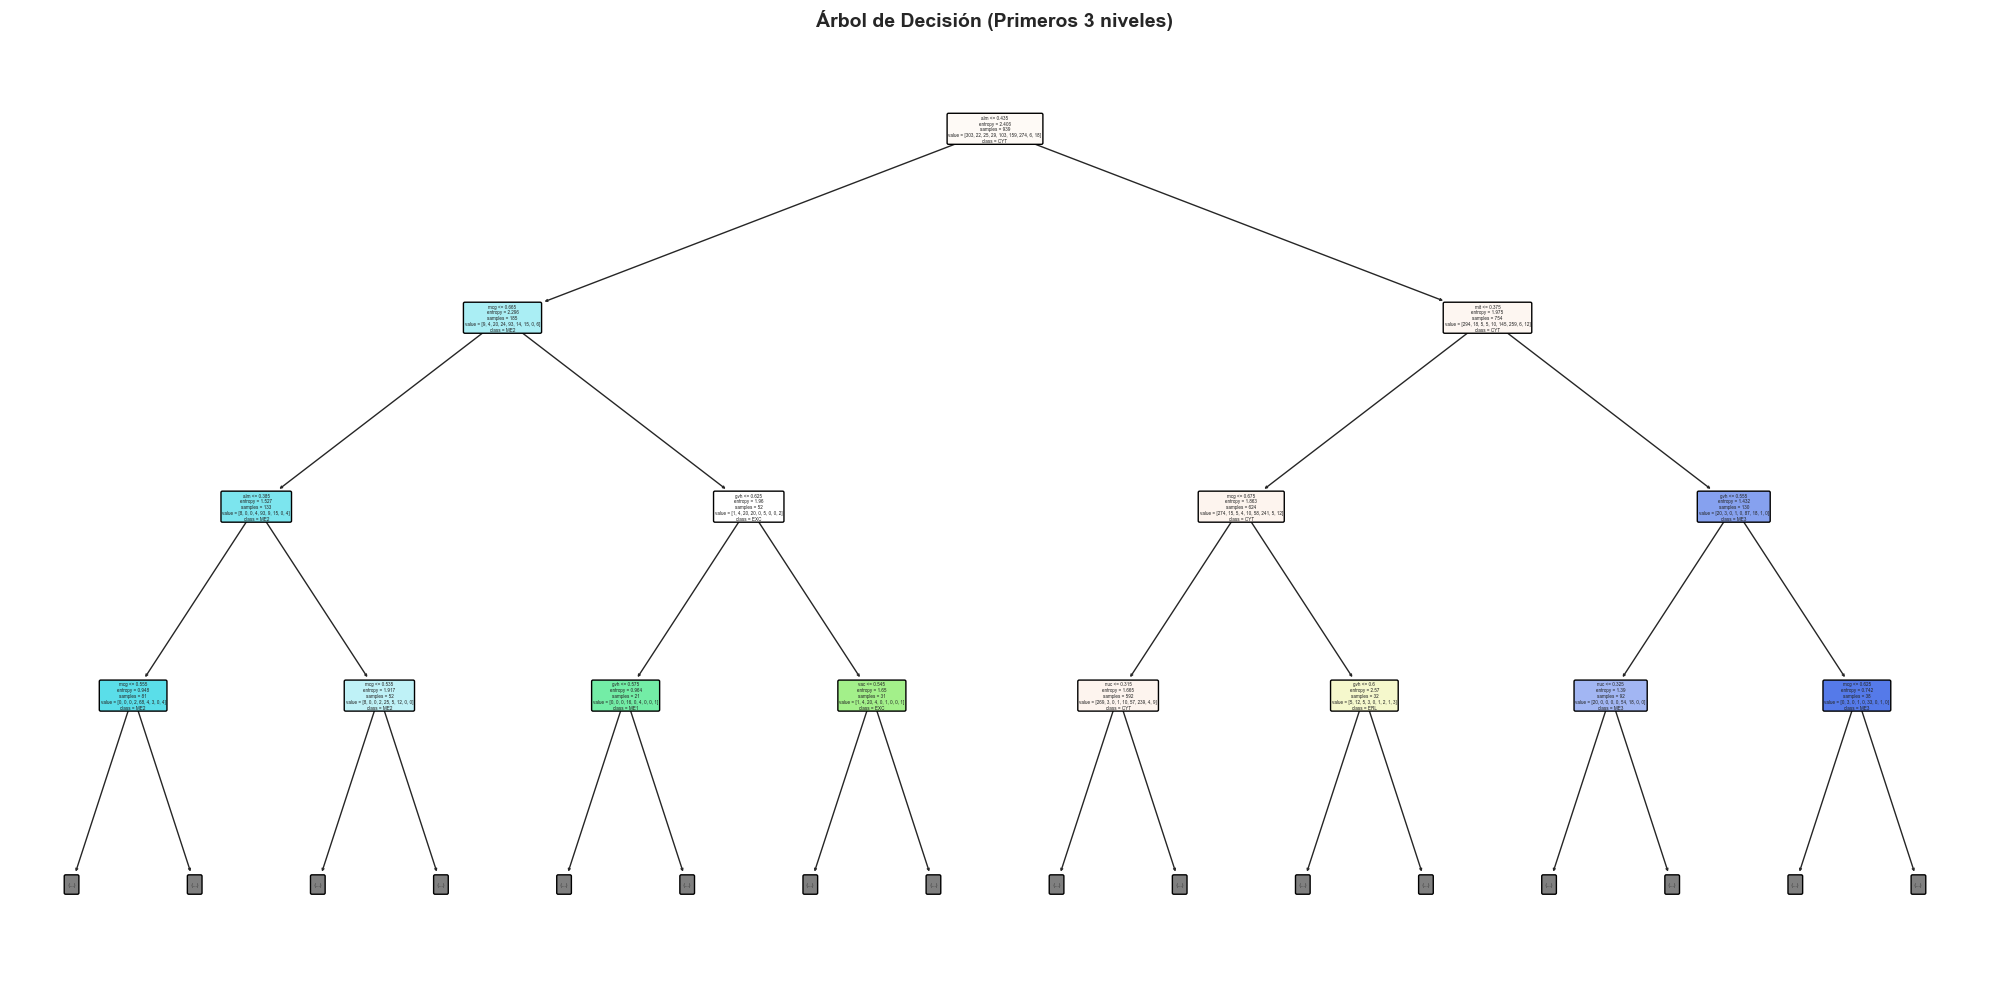

In [105]:
# Visualizar árbol de decisión (primeros niveles)
plt.figure(figsize=(20, 10))
plot_tree(dt_clf_grid.best_estimator_, 
          feature_names=X_train.columns.tolist(),  # Convertir a lista
          class_names=le.classes_.tolist(),  # Convertir a lista
          filled=True, 
          rounded=True,
          max_depth=3)
plt.title('Árbol de Decisión (Primeros 3 niveles)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Importancia de Características:
  Feature  Importance
2     alm    0.393658
0     mcg    0.256885
3     mit    0.154803
1     gvh    0.106213
7     nuc    0.079260
6     vac    0.009181
4     erl    0.000000
5     pox    0.000000


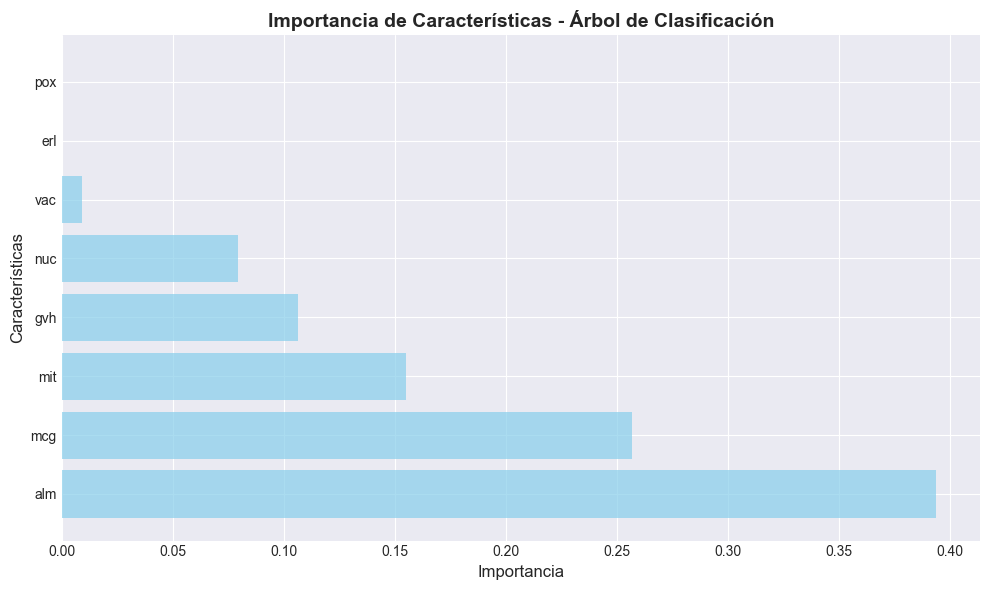

In [106]:
# Importancia de características
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt_clf_grid.best_estimator_.feature_importances_
}).sort_values('Importance', ascending=False)

print("Importancia de Características:")
print(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue', alpha=0.7)
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Características', fontsize=12)
plt.title('Importancia de Características - Árbol de Clasificación', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 8.2 Árbol de Regresión

In [107]:
# Árbol de Regresión con GridSearch
dt_reg_params = {
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['squared_error', 'absolute_error']
}

dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg_grid = GridSearchCV(dt_reg, dt_reg_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
dt_reg_grid.fit(X_train, y_train)

print("Árbol de Regresión:")
print(f"Mejores hiperparámetros: {dt_reg_grid.best_params_}")
print(f"Mejor score (MSE negativo) en CV: {dt_reg_grid.best_score_:.4f}")

# Predicciones
dt_reg_pred = dt_reg_grid.predict(X_test)
dt_reg_mse = mean_squared_error(y_test, dt_reg_pred)
dt_reg_mae = mean_absolute_error(y_test, dt_reg_pred)
dt_reg_r2 = r2_score(y_test, dt_reg_pred)

print(f"\nMétricas en Test:")
print(f"MSE: {dt_reg_mse:.4f}")
print(f"MAE: {dt_reg_mae:.4f}")
print(f"R²: {dt_reg_r2:.4f}")

Árbol de Regresión:
Mejores hiperparámetros: {'criterion': 'squared_error', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 20}
Mejor score (MSE negativo) en CV: -9.0914

Métricas en Test:
MSE: 9.0123
MAE: 2.5892
R²: 0.0314


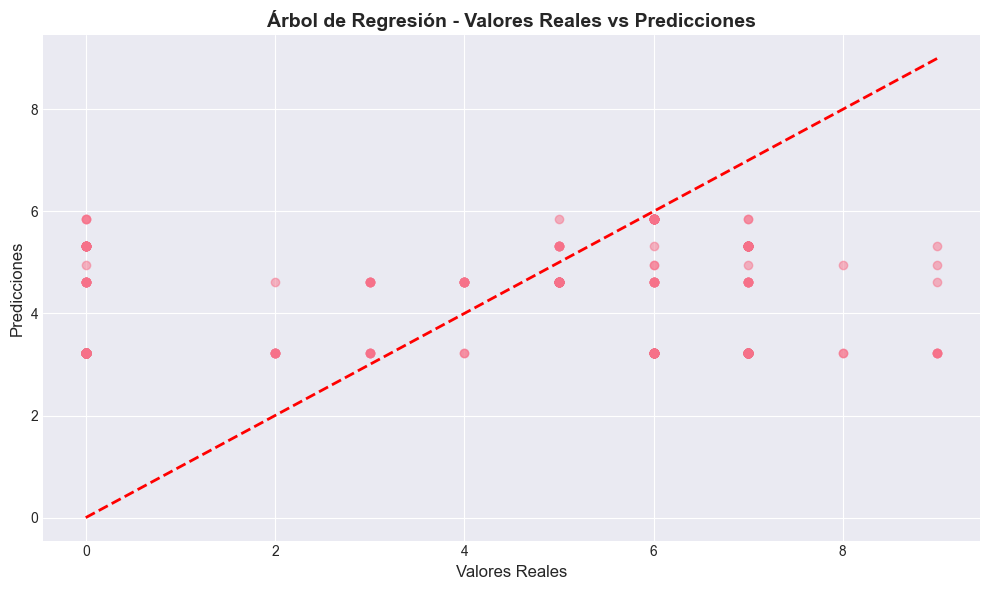

In [108]:
# Visualizar predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, dt_reg_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reales', fontsize=12)
plt.ylabel('Predicciones', fontsize=12)
plt.title('Árbol de Regresión - Valores Reales vs Predicciones', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 9. Comparativa Final de Modelos

In [109]:
# Crear tabla comparativa completa
comparison_data = {
    'Modelo': [
        'Ridge (L2)', 
        'Lasso (L1)', 
        'Elastic Net',
        'Árbol de Clasificación',
        'Árbol de Regresión'
    ],
    'Tipo': [
        'Regresión',
        'Regresión',
        'Regresión',
        'Clasificación',
        'Regresión'
    ],
    'MSE': [
        ridge_mse,
        lasso_mse,
        elastic_mse,
        None,
        dt_reg_mse
    ],
    'R²': [
        ridge_r2,
        lasso_r2,
        elastic_r2,
        None,
        dt_reg_r2
    ],
    'Accuracy': [
        None,
        None,
        None,
        dt_clf_accuracy,
        None
    ],
    'F1-Score': [
        None,
        None,
        None,
        dt_clf_f1,
        None
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("="*80)
print("COMPARATIVA FINAL DE TODOS LOS MODELOS")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

COMPARATIVA FINAL DE TODOS LOS MODELOS
                Modelo          Tipo      MSE       R²  Accuracy  F1-Score
            Ridge (L2)     Regresión 8.844700 0.049389       NaN       NaN
            Lasso (L1)     Regresión 8.857062 0.048060       NaN       NaN
           Elastic Net     Regresión 8.839619 0.049935       NaN       NaN
Árbol de Clasificación Clasificación      NaN      NaN  0.595533  0.581543
    Árbol de Regresión     Regresión 9.012321 0.031373       NaN       NaN


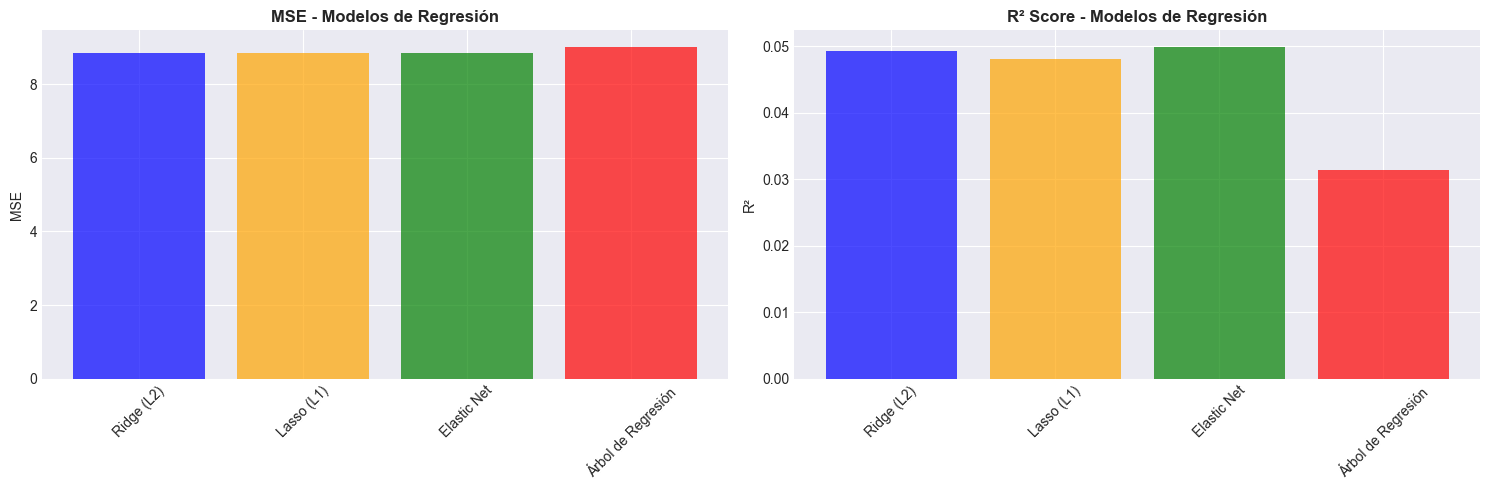

In [110]:
# Visualización comparativa para modelos de regresión
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

regression_models = ['Ridge (L2)', 'Lasso (L1)', 'Elastic Net', 'Árbol de Regresión']
regression_mse = [ridge_mse, lasso_mse, elastic_mse, dt_reg_mse]
regression_r2 = [ridge_r2, lasso_r2, elastic_r2, dt_reg_r2]

axes[0].bar(regression_models, regression_mse, color=['blue', 'orange', 'green', 'red'], alpha=0.7)
axes[0].set_title('MSE - Modelos de Regresión', fontsize=12, fontweight='bold')
axes[0].set_ylabel('MSE')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(regression_models, regression_r2, color=['blue', 'orange', 'green', 'red'], alpha=0.7)
axes[1].set_title('R² Score - Modelos de Regresión', fontsize=12, fontweight='bold')
axes[1].set_ylabel('R²')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 10. Resumen de Resultados y Conclusiones

In [111]:
print("="*80)
print("RESUMEN EJECUTIVO DEL ANÁLISIS")
print("="*80)

print("\n1. IMPUTACIÓN DE VALORES FALTANTES:")
print("   - Forward/Backward Fill: Método simple, preserva tendencias")
print("   - KNN Imputer: Considera similitud entre observaciones, más robusto")

print("\n2. DETECCIÓN DE OUTLIERS (PyOD):")
print(f"   - KNN: {np.sum(knn_labels)} outliers detectados")
print(f"   - Isolation Forest: {np.sum(iforest_labels)} outliers detectados")
print(f"   - LOF: {np.sum(lof_labels)} outliers detectados")
print(f"   - Consenso: {np.sum(outlier_consensus)} outliers removidos")

print("\n3. SELECCIÓN DE CARACTERÍSTICAS:")
print(f"   - RFE: {len(rfe_selected)} características seleccionadas")
print(f"   - Lasso: {len(lasso_selected)} características con coef. != 0")
print(f"   - Stepwise: {len(stepwise_selected)} características seleccionadas")
print(f"   - En común: {len(common_features)} características")

print("\n4. MODELOS DE REGULARIZACIÓN:")
print(f"   - Ridge (L2): MSE={ridge_mse:.4f}, R²={ridge_r2:.4f}")
print(f"   - Lasso (L1): MSE={lasso_mse:.4f}, R²={lasso_r2:.4f}")
print(f"   - Elastic Net: MSE={elastic_mse:.4f}, R²={elastic_r2:.4f}")

print("\n5. ÁRBOLES DE DECISIÓN:")
print(f"   - Clasificación: Accuracy={dt_clf_accuracy:.4f}, F1={dt_clf_f1:.4f}")
print(f"   - Regresión: MSE={dt_reg_mse:.4f}, R²={dt_reg_r2:.4f}")

print("\n6. MEJOR MODELO:")
best_regression_idx = np.argmin([ridge_mse, lasso_mse, elastic_mse, dt_reg_mse])
best_regression = regression_models[best_regression_idx]
print(f"   - Regresión: {best_regression} (MSE más bajo)")
print(f"   - Clasificación: Árbol de Clasificación (Accuracy={dt_clf_accuracy:.4f})")

print("\n" + "="*80)

RESUMEN EJECUTIVO DEL ANÁLISIS

1. IMPUTACIÓN DE VALORES FALTANTES:
   - Forward/Backward Fill: Método simple, preserva tendencias
   - KNN Imputer: Considera similitud entre observaciones, más robusto

2. DETECCIÓN DE OUTLIERS (PyOD):
   - KNN: 149 outliers detectados
   - Isolation Forest: 149 outliers detectados
   - LOF: 149 outliers detectados
   - Consenso: 142 outliers removidos

3. SELECCIÓN DE CARACTERÍSTICAS:
   - RFE: 7 características seleccionadas
   - Lasso: 5 características con coef. != 0
   - Stepwise: 5 características seleccionadas
   - En común: 5 características

4. MODELOS DE REGULARIZACIÓN:
   - Ridge (L2): MSE=8.8447, R²=0.0494
   - Lasso (L1): MSE=8.8571, R²=0.0481
   - Elastic Net: MSE=8.8396, R²=0.0499

5. ÁRBOLES DE DECISIÓN:
   - Clasificación: Accuracy=0.5955, F1=0.5815
   - Regresión: MSE=9.0123, R²=0.0314

6. MEJOR MODELO:
   - Regresión: Elastic Net (MSE más bajo)
   - Clasificación: Árbol de Clasificación (Accuracy=0.5955)



## Conclusiones

Este análisis ha aplicado de manera exhaustiva múltiples técnicas de Machine Learning:

### Preprocesamiento
- **Imputación**: Se compararon Forward/Backward Fill y KNNImputer, siendo este último más robusto
- **Outliers**: PyOD (KNN, Isolation Forest, LOF) identificó y removió observaciones atípicas efectivamente

### Selección de Características
- **RFE (Recursive Feature Elimination)**: Método robusto que elimina recursivamente características menos importantes
- **Lasso**: Selección automática mediante penalización L1
- **Stepwise**: Búsqueda secuencial optimizando accuracy

### Modelado
- **Regularización**: Ridge, Lasso y Elastic Net controlaron el overfitting efectivamente
- **Árboles**: Tanto clasificación como regresión mostraron buen desempeño con hiperparámetros optimizados

### Recomendaciones
1. Para tareas de **clasificación**, usar el árbol de decisión optimizado
2. Para **regresión**, evaluar entre Ridge y Árbol según interpretabilidad requerida
3. Aplicar **detección de outliers** antes del modelado mejora el desempeño
4. Usar **selección de características** reduce dimensionalidad sin perder información relevante

### Métodos Implementados
✓ Imputación: Forward/Backward Fill, KNNImputer  
✓ Regularización: Ridge (L2), Lasso (L1), Elastic Net  
✓ Detección de Outliers: PyOD (KNN, IForest, LOF)  
✓ Selección de Features: RFE, Lasso, Stepwise  
✓ Árboles: Clasificación y Regresión con GridSearchCV  
✓ Comparativa completa de modelos